<a href="https://colab.research.google.com/github/MariaExtrella/TFM/blob/main/04_Modelo_VSR_fallido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import joblib
import json

In [2]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

# **Funciones de carga y limpieza del dataset de cada Arduino**

**Cargar los datos de los 3 ficheros de Arduinos**

In [4]:
# Función para cargar datos de Arduino
def cargar_arduino(filepath, nombre_arduino):
    # Leer todo el fichero como texto para limpiarlo
    df = pd.read_csv(
        filepath,
        sep=';',
        header=None,
        dtype=str,
        encoding='latin-1',
        on_bad_lines='skip'
    )

    # Buscar filas que contienen la cabecera real
    mask_header = df[0].str.contains('FECHA', na=False)

    # Obtener los nombres de columnas de la primera cabecera encontrada
    if mask_header.any():
        header_idx = mask_header.idxmax()
        column_names = df.iloc[header_idx].tolist()
    else:
        raise ValueError(f"No se encontró cabecera válida en {filepath}")

    # Intentar convertir a datetime, lo que no sea fecha queda como NaT
    df['datetime'] = pd.to_datetime(df[0], format='%d/%m/%Y %H:%M:%S', errors='coerce')

    # Quedarse solo con las filas que tienen fecha válida
    df_clean = df[df['datetime'].notna()].copy()

    # Eliminar columna 0 (fecha original) y quedarnos con las numéricas
    df_clean = df_clean.drop(columns=[0])

    # Convertir decimales (coma -> punto) en columnas numéricas (no datetime)
    for col in df_clean.columns:
        if col != 'datetime':
            df_clean[col] = df_clean[col].str.replace(',', '.').astype(float)

    # Asignar nombres de columnas (sin la fecha, que ya es 'datetime')
    cols_numericas = column_names[1:]  # Quitar 'FECHA y HORA'
    df_clean.columns = cols_numericas + ['datetime']

    # Añadir sufijo para identificar el arduino (excepto datetime)
    df_clean.columns = [f"{col}_{nombre_arduino}" if col != 'datetime' else col
                        for col in df_clean.columns]

    # Quedarse con el primer registro de cada timestamp
    df_clean = df_clean.drop_duplicates(subset='datetime', keep='first')

    return df_clean

In [5]:
ruta_base = 'https://raw.githubusercontent.com/MariaExtrella/TFM/refs/heads/main/arduino2.csv'

# Cargar cada dataset
df_a2 = cargar_arduino(ruta_base, 'A2')


**Eliminar outliers del dataset de Arduino**

In [6]:
# Eliminar radiación gamma con valores imposibles (>500 parece error)
df_a2.loc[df_a2['GDK101: Radi 10.2_A2'] > 500, 'GDK101: Radi 10.2_A2'] = np.nan

# Eliminar filas en las que coinciden valores de temperatura, humedad y CO2 a 0 en A2
cols_scd30_a2 = ['SCD30: Temp._A2', 'SCD30: Humedad r._A2', 'SCD30: CO2_A2']
ceros_a2 = (df_a2[cols_scd30_a2] == 0).any(axis=1)
df_a2.loc[ceros_a2, cols_scd30_a2] = np.nan

# Aplicar la regla PM1.0 ≤ PM2.5 ≤ PM10
# Definir condición de registros INVÁLIDOS (violan la regla)
invalidos_a2 = (df_a2['PMS5003: PM 1.0_A2'] > df_a2['PMS5003: PM 2.5_A2']) | \
               (df_a2['PMS5003: PM 2.5_A2'] > df_a2['PMS5003: PM 10_A2'])

# Marcar como NaN las columnas de PM
df_a2.loc[invalidos_a2, ['PMS5003: PM 1.0_A2', 'PMS5003: PM 2.5_A2', 'PMS5003: PM 10_A2']] = np.nan


In [7]:
# Ordenar los datos de los Arduinos por fecha
df_a2 = df_a2.sort_values('datetime').reset_index(drop=True)


In [8]:
# Antes del resample, comprobar frecuencia original
print("Intervalo entre mediciones A2:")
print(df_a2['datetime'].diff().describe())


Intervalo entre mediciones A2:
count                         5208
mean     0 days 00:30:41.432987711
std      0 days 15:07:33.864383239
min                0 days 00:01:58
25%                0 days 00:09:23
50%                0 days 00:09:28
75%                0 days 00:09:36
max               41 days 19:09:46
Name: datetime, dtype: object


In [9]:
def preparar_dataset_arduino(df_a2):
    """
    Prepara el dataset con los datos del Arduino para unirlo
    posteriormente con el dataset de la estación meteorológica.
    Devuelve el dataset con los nombres de columna sin el sufijo
    _A2 y remuestreado con frecuencia de 10 minutos.
    """

    def normalizar_columnas(df, sufijo):
        '''
        Función para quitar sufijo del Arduino.
        Devuelve las columnas con el nombre sin sufijo.
        '''
        df = df.copy()
        nuevas_cols = {}
        for col in df.columns:
            if col == 'datetime':
                nuevas_cols[col] = col
            else:
                # Quitar el sufijo _A2
                nuevo_nombre = col.replace(f'_{sufijo}', '')
                nuevas_cols[col] = nuevo_nombre
        return df.rename(columns=nuevas_cols)

    # Normalizar nombres de columnas
    df_a2_norm = normalizar_columnas(df_a2, 'A2')

    # Resample
    resultado = df_a2_norm.set_index('datetime').resample('10min').mean()

    # Eliminar filas completamente vacías
    resultado = resultado.dropna(how='all')

    return resultado

# Aplicar con prioridad A1 > A2 > A3
df_arduinos_final = preparar_dataset_arduino(df_a2)

print(f"Registros totales: {len(df_arduinos_final)}")
print(f"\nOrigen de datos:")
print(f"\nColumnas: {df_arduinos_final.columns.tolist()}")

Registros totales: 4683

Origen de datos:

Columnas: ['PMS5003: PM 1.0', 'PMS5003: PM 2.5', 'PMS5003: PM 10', 'DHT22: Temp.', 'DHT22: Humedad r.', 'MQ-7: CO', 'SHT85: Temp.', 'SHT85: Humedad r.', 'GDK101: Radi 10.2', 'SCD30: Temp.', 'SCD30: Humedad r.', 'SCD30: CO2']


In [10]:
df_arduinos_final.head()

,PMS5003: PM 1.0,PMS5003: PM 2.5,PMS5003: PM 10,DHT22: Temp.,DHT22: Humedad r.,MQ-7: CO,SHT85: Temp.,SHT85: Humedad r.,GDK101: Radi 10.2,SCD30: Temp.,SCD30: Humedad r.,SCD30: CO2
datetime,,,,,,,,,,,,
2025-07-31 08:50:00,10.90,22.20,26.70,31.570,57.640,6.940,29.390,42.330,6.670,30.090,42.960,271.380
2025-08-17 11:20:00,18.90,32.20,37.10,33.130,46.050,2.580,33.360,40.610,16.440,33.870,39.720,388.320
2025-08-17 11:30:00,20.98,35.16,39.78,33.634,43.376,0.888,35.864,40.452,15.956,35.618,40.560,376.300
2025-08-17 11:40:00,21.98,36.06,41.78,34.626,42.064,0.798,37.864,37.518,11.530,37.030,38.680,368.048
2025-08-17 11:50:00,23.18,35.58,40.68,35.248,41.332,0.800,38.826,36.252,9.224,37.896,37.412,362.234


In [11]:
print(df_arduinos_final.isna().sum())

PMS5003: PM 1.0       1
PMS5003: PM 2.5       1
PMS5003: PM 10        1
DHT22: Temp.          0
DHT22: Humedad r.     0
MQ-7: CO              0
SHT85: Temp.          0
SHT85: Humedad r.     0
GDK101: Radi 10.2    97
SCD30: Temp.         64
SCD30: Humedad r.    64
SCD30: CO2           64
dtype: int64


**Matriz de correlación de las variables del Arduino**

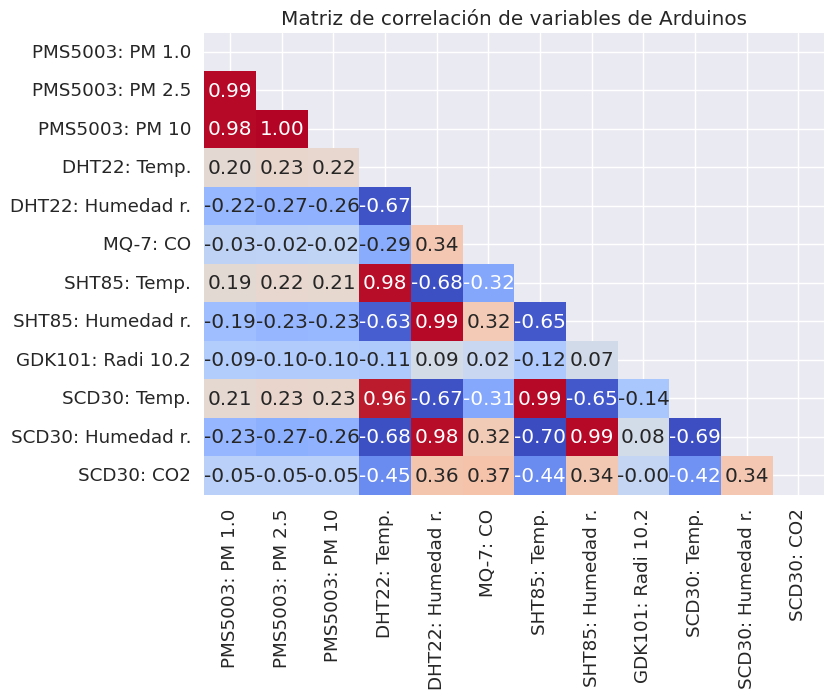

In [12]:
correlation_matrix = df_arduinos_final.corr(numeric_only=True)

# Crear una máscara para ocultar la mitad superior de la matriz (simetría)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=False, mask=mask)

plt.title("Matriz de correlación de variables de Arduinos")
plt.show()


Las columnas que presentan mucha correlación, como las de la Temperatura y la Humedad relativa, se eliminan,
dejando solamente las del sensor SHT85. También se eliminan las columnas de PM de diámetro 1.0 y 10.

In [13]:
# Eliminar las columnas que no se necesitan
cols_drop = [
    'PMS5003: PM 1.0',
    'PMS5003: PM 10',
    'DHT22: Temp.',
    'DHT22: Humedad r.',
    'SCD30: Temp.',
    'SCD30: Humedad r.'
]

df_arduinos_clean = df_arduinos_final.drop(columns=cols_drop, axis=1)


In [14]:
df_arduinos_clean.head()

,PMS5003: PM 2.5,MQ-7: CO,SHT85: Temp.,SHT85: Humedad r.,GDK101: Radi 10.2,SCD30: CO2
datetime,,,,,,
2025-07-31 08:50:00,22.20,6.940,29.390,42.330,6.670,271.380
2025-08-17 11:20:00,32.20,2.580,33.360,40.610,16.440,388.320
2025-08-17 11:30:00,35.16,0.888,35.864,40.452,15.956,376.300
2025-08-17 11:40:00,36.06,0.798,37.864,37.518,11.530,368.048
2025-08-17 11:50:00,35.58,0.800,38.826,36.252,9.224,362.234


# **Carga y limpieza de los datos del sensor de radón Airthings**

**Función para cargar los datos del fichero airthings**

In [15]:
def cargar_airthings(filepath):
    '''
    Función para cargar los datos del fichero airthings.csv.
    Añade el sufijo _airthings a las columnas de los datos del sensor.
    Devuelve el dataframe con los datos del sensor.
    '''
    df = pd.read_csv(
        filepath,
        sep=';',
        header=None,
        dtype=str,
        encoding='utf-8',
        on_bad_lines='skip'
    )

    # La primera fila es la cabecera
    column_names = df.iloc[0].tolist()

    # Convertir la columna de la fecha
    df['datetime'] = pd.to_datetime(df[0], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Quedarse solo con las filas que tienen fecha válida
    df_clean = df[df['datetime'].notna()].copy()

    # Asignar nombres de columnas
    df_clean.columns = column_names + ['datetime']

    # Convertir tipos numéricos
    numeric_cols = list(df_clean.columns.values)
    numeric_cols.remove('datetime')
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    df_clean = df_clean.drop(columns=['fechayhora'])

    # Renombrar columnas para claridad en análisis posterior
    rename_dict = {col: f"{col}_airthings" for col in numeric_cols}
    df_clean = df_clean.rename(columns=rename_dict)

    # Quedarse con el primer registro de cada timestamp
    df_clean = df_clean.drop_duplicates(subset='datetime', keep='first')

    return df_clean


In [16]:
# Cargar datos de radón
ruta_base = 'https://raw.githubusercontent.com/MariaExtrella/TFM/refs/heads/main/airthings.csv'
df_radon = cargar_airthings(ruta_base)
df_radon.head()

,radon_airthings,temperatura_airthings,humedadr_airthings,presion_airthings,co2_airthings,voc_airthings,datetime
1,159.0,27.1,53.0,955.0,646.0,146.0,2025-08-13 10:23:36
3,159.0,27.1,53.0,954.0,633.0,163.0,2025-08-13 10:24:22
5,159.0,27.1,53.0,954.0,633.0,163.0,2025-08-13 10:28:37
7,159.0,27.1,53.0,954.0,630.0,163.0,2025-08-13 10:31:11
8,159.0,27.1,53.0,954.0,630.0,163.0,2025-08-13 10:36:31


In [17]:
# Resample del dataframe de radón
df_radon_r = df_radon.set_index('datetime').resample('10min').mean()

# Ordenar los datos por fecha
df_radon_r = df_radon_r.sort_index()
df_radon_r.head()

,radon_airthings,temperatura_airthings,humedadr_airthings,presion_airthings,co2_airthings,voc_airthings
datetime,,,,,,
2025-08-13 10:20:00,159.0,27.1,53.0,954.333333,637.333333,157.333333
2025-08-13 10:30:00,159.0,27.1,53.0,954.000000,630.000000,163.000000
2025-08-13 10:40:00,159.0,27.1,53.0,954.000000,638.000000,160.000000
2025-08-13 10:50:00,159.0,27.1,53.0,954.000000,641.000000,157.000000
2025-08-13 11:00:00,159.0,27.1,53.0,954.000000,640.000000,166.000000


# **Carga y limpieza de los datos de la estación meteorológica**

In [18]:
def cargar_wunder(filepath):
    '''
    Función para cargar los datos del fichero wunder.csv.
    Añade el sufijo _meteo a las columnas de los datos del sensor.
    Elimina las colunnas 'Direccion' y 'Elevacion' porque tiene un valor constante,
    ya que solo se tiene una estación meteorológica.
    Devuelve el dataframe con los datos del sensor.
    '''
    df = pd.read_csv(
        filepath,
        sep=';',
        header=None,
        dtype=str,
        encoding='utf-8',
        on_bad_lines='skip'
    )

    # La primera fila es la cabecera
    column_names = df.iloc[0].tolist()

    # Convertir a datetime (formato ISO, no europeo)
    df['datetime'] = pd.to_datetime(df[0], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Quedarse solo con las filas que tienen fecha válida
    df_clean = df[df['datetime'].notna()].copy()

    # Eliminar columna 0 y asignar nombres
    df_clean = df_clean.drop(columns=[0])
    df_clean.columns = column_names[1:] + ['datetime']

    # Obtener nombre de las columnas numéricas
    numeric_cols = list(df_clean.columns.values)
    numeric_cols.remove('datetime')

    # Convertir tipos numéricos
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    df_clean = df_clean.drop(columns=['Direccion'])

    # Renombrar con sufijo _meteo
    rename_dict = {col: f"{col}_meteo" for col in df_clean.columns if col != 'datetime'}
    df_clean = df_clean.rename(columns=rename_dict)

    # Quedarse con el primer registro de cada timestamp
    df_clean = df_clean.drop_duplicates(subset='datetime', keep='first')

    return df_clean

In [19]:
ruta_base = 'https://raw.githubusercontent.com/MariaExtrella/TFM/refs/heads/main/wunder.csv'
df_meteo = cargar_wunder(ruta_base)
df_meteo.head()

,Temperatura_meteo,Indice de Calor_meteo,Punto de Rocio_meteo,Sensación Termica_meteo,Velocidad del Viento_meteo,Rafaga de Viento_meteo,Presion_meteo,Tasa de Precipitacion_meteo,Total de Precipitacion_meteo,Elevacion_meteo,Humedad_meteo,datetime
1,39.6,38.3,10.9,39.6,0.4,1.8,1013.99,0.0,0.0,160.9,18,2025-08-13 14:16:05
2,39.6,38.3,10.9,39.6,0.0,0.0,1013.99,0.0,0.0,160.9,18,2025-08-13 14:16:22
3,39.7,38.4,11.0,39.7,0.4,1.8,1013.72,0.0,0.0,160.9,18,2025-08-13 14:16:39
4,40.3,38.6,9.7,40.3,4.0,7.2,1013.88,0.0,0.0,160.9,16,2025-08-13 14:20:55
6,39.3,37.8,10.7,39.3,1.1,1.8,1013.72,0.0,0.0,160.9,18,2025-08-13 14:31:33


In [20]:
# Resample del dataframe de la estación meteorológica
df_meteo_r = df_meteo.set_index('datetime').resample('10min').mean()

# Ordenar los datos por fecha
df_meteo_r = df_meteo_r.sort_index()
df_meteo_r.head()

,Temperatura_meteo,Indice de Calor_meteo,Punto de Rocio_meteo,Sensación Termica_meteo,Velocidad del Viento_meteo,Rafaga de Viento_meteo,Presion_meteo,Tasa de Precipitacion_meteo,Total de Precipitacion_meteo,Elevacion_meteo,Humedad_meteo
datetime,,,,,,,,,,,
2025-08-13 14:10:00,39.633333,38.333333,10.933333,39.633333,0.266667,1.2,1013.900000,0.0,0.0,160.9,18.000000
2025-08-13 14:20:00,40.300000,38.600000,9.700000,40.300000,4.000000,7.2,1013.880000,0.0,0.0,160.9,16.000000
2025-08-13 14:30:00,39.550000,38.000000,10.450000,39.550000,0.550000,0.9,1013.800000,0.0,0.0,160.9,17.500000
2025-08-13 14:40:00,39.866667,38.533333,10.833333,39.866667,2.900000,4.8,1013.683333,0.0,0.0,160.9,17.666667
2025-08-13 14:50:00,39.900000,38.400000,10.300000,39.900000,3.050000,3.6,1013.770000,0.0,0.0,160.9,17.000000


In [21]:
# Eliminar las variables de la estación meteorológica que no se van a utilizar
df_meteo_final = df_meteo_r.copy()
df_meteo_final = df_meteo_final.drop(columns=['Sensación Termica_meteo', 'Indice de Calor_meteo', 'Elevacion_meteo', 'Rafaga de Viento_meteo', 'Tasa de Precipitacion_meteo'], axis=1)
df_meteo_final.head()

,Temperatura_meteo,Punto de Rocio_meteo,Velocidad del Viento_meteo,Presion_meteo,Total de Precipitacion_meteo,Humedad_meteo
datetime,,,,,,
2025-08-13 14:10:00,39.633333,10.933333,0.266667,1013.900000,0.0,18.000000
2025-08-13 14:20:00,40.300000,9.700000,4.000000,1013.880000,0.0,16.000000
2025-08-13 14:30:00,39.550000,10.450000,0.550000,1013.800000,0.0,17.500000
2025-08-13 14:40:00,39.866667,10.833333,2.900000,1013.683333,0.0,17.666667
2025-08-13 14:50:00,39.900000,10.300000,3.050000,1013.770000,0.0,17.000000


**Unir los datasets para la entrada al modelo**

In [22]:
# 1. Unir datasets
df_merge = pd.merge(
    left=df_arduinos_clean,
    right=df_radon_r['radon_airthings'],
    left_index=True,
    right_index=True,
    how='inner'
)
print(f"Registros tras unir con Airthings: {len(df_merge)}")

df_final_nuevo = pd.merge(
    left=df_merge,
    right=df_meteo_final,
    left_index=True,
    right_index=True,
    how='left'
)
print(f"Registros tras unir con estación meteorológica: {len(df_final_nuevo)}")

# 2. Interpolar SOLO las features (no el radón)
columnas_features = [col for col in df_final_nuevo.columns if col != 'radon_airthings']
df_final_nuevo[columnas_features] = df_final_nuevo[columnas_features].interpolate(method='time', limit=3)

# 3. Eliminar filas donde el radón sea NaN (no inventar valores del target)
df_final_nuevo = df_final_nuevo.dropna(subset=['radon_airthings'])

# 4. Eliminar filas donde las features aún tengan NaN
df_final_nuevo = df_final_nuevo.dropna()

print(f"Registros finales: {len(df_final_nuevo)}")
print(f"Rango: {df_final_nuevo.index.min()} a {df_final_nuevo.index.max()}")


Registros tras unir con Airthings: 4682
Registros tras unir con estación meteorológica: 4682
Registros finales: 3236
Rango: 2025-08-17 11:30:00 a 2025-11-19 08:50:00


# **Feature Engineering (Enriquecer el dataset con variables con retardo)**

In [23]:
# Limpiar nombres de columnas
def limpiar_nombre(nombre):
    nombre = nombre.replace(':', '_').replace(' ', '_').replace('.', '').replace('__', '_')
    nombre = re.sub(r'[^\w]', '', nombre)
    return nombre

df_modelo_a2 = df_final_nuevo.copy()
df_modelo_a2.columns = [limpiar_nombre(col) for col in df_modelo_a2.columns]
df_modelo_a2.columns

Index(['PMS5003_PM_25', 'MQ7_CO', 'SHT85_Temp', 'SHT85_Humedad_r',
       'GDK101_Radi_102', 'SCD30_CO2', 'radon_airthings', 'Temperatura_meteo',
       'Punto_de_Rocio_meteo', 'Velocidad_del_Viento_meteo', 'Presion_meteo',
       'Total_de_Precipitacion_meteo', 'Humedad_meteo'],
      dtype='object')

In [24]:
# Features temporales
df_modelo_a2['Hora'] = df_modelo_a2.index.hour
df_modelo_a2['Mes'] = df_modelo_a2.index.month
df_modelo_a2['Hora_Sin'] = np.sin(2 * np.pi * df_modelo_a2['Hora'] / 24.0)
df_modelo_a2['Hora_Cos'] = np.cos(2 * np.pi * df_modelo_a2['Hora'] / 24.0)
df_modelo_a2['Mes_Sin'] = np.sin(2 * np.pi * df_modelo_a2['Mes'] / 12.0)
df_modelo_a2['Mes_Cos'] = np.cos(2 * np.pi * df_modelo_a2['Mes'] / 12.0)

# Features derivadas CON LAGS ÓPTIMOS PARA A2
df_modelo_a2['Presion_Lag_6h'] = df_modelo_a2['Presion_meteo'].shift(36)           # 6h = 36 intervalos
df_modelo_a2['Humedad_Lag_4h'] = df_modelo_a2['SHT85_Humedad_r'].shift(24)         # 4h = 24 intervalos
df_modelo_a2['Temp_Int_Media_10h'] = df_modelo_a2['SHT85_Temp'].rolling(60).mean() # 10h = 60 intervalos

# Tendencias
df_modelo_a2['Presion_Tendencia_6h'] = df_modelo_a2['Presion_meteo'].diff(36)
df_modelo_a2['Humedad_Tendencia_4h'] = df_modelo_a2['SHT85_Humedad_r'].diff(24)
df_modelo_a2['Temp_Int_Tendencia_6h'] = df_modelo_a2['SHT85_Temp'].diff(36)

# Media de presión (ajustar a 6h también)
df_modelo_a2['Presion_Media_6h'] = df_modelo_a2['Presion_meteo'].rolling(36).mean()

# Crear diferencia de humedad
df_modelo_a2['Diff_Hum_In_Out'] = df_modelo_a2['SHT85_Humedad_r'] - df_modelo_a2['Humedad_meteo']

# Eliminar NaN generados por los lags
df_modelo_a2 = df_modelo_a2.dropna()

print(f"Registros finales: {len(df_modelo_a2)}")

Registros finales: 3177


In [25]:
df_modelo_a2.columns


Index(['PMS5003_PM_25', 'MQ7_CO', 'SHT85_Temp', 'SHT85_Humedad_r',
       'GDK101_Radi_102', 'SCD30_CO2', 'radon_airthings', 'Temperatura_meteo',
       'Punto_de_Rocio_meteo', 'Velocidad_del_Viento_meteo', 'Presion_meteo',
       'Total_de_Precipitacion_meteo', 'Humedad_meteo', 'Hora', 'Mes',
       'Hora_Sin', 'Hora_Cos', 'Mes_Sin', 'Mes_Cos', 'Presion_Lag_6h',
       'Humedad_Lag_4h', 'Temp_Int_Media_10h', 'Presion_Tendencia_6h',
       'Humedad_Tendencia_4h', 'Temp_Int_Tendencia_6h', 'Presion_Media_6h',
       'Diff_Hum_In_Out'],
      dtype='object')

# **Modelo SVR**

**Variables que entrarán en el modelo**

In [26]:
features_a2 = [
    # Arduino (sin GDK101)
    'MQ7_CO',
    'SHT85_Temp',
    'SHT85_Humedad_r',
    'SCD30_CO2',
    'PMS5003_PM_25',

    # Meteo
    'Temperatura_meteo',
    'Velocidad_del_Viento_meteo',
    'Presion_meteo',
    'Total_de_Precipitacion_meteo',
    'Humedad_meteo',

    # Temporales
    'Hora_Sin', 'Hora_Cos', 'Mes_Sin', 'Mes_Cos',

    # Derivadas (lags óptimos para A2)
    'Presion_Lag_6h',
    'Humedad_Lag_4h',
    'Temp_Int_Media_10h',
    'Presion_Tendencia_6h',
    'Humedad_Tendencia_4h',
    'Temp_Int_Tendencia_6h',
    'Presion_Media_6h',

    # Diferencia interior/exterior
    'Diff_Hum_In_Out'
]

print(f"Total features: {len(features_a2)}")

Total features: 22


**Entrenamiento del modelo**

In [27]:
horizontes = {
    '30min': 3,
    '1h': 6,
    '2h': 12,
    '3h': 18,
    '6h': 36
}

for nombre_horizonte, horizonte in horizontes.items():
    print(f"\n{'='*60}")
    print(f"HORIZONTE: {nombre_horizonte}")
    print('='*60)

    # Preparar datos
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_a2]
    y = df_temp['radon_futuro']

    # Split 80/20
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Crear un Pipeline que escala y entrena a la vez
    modelo_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=10, epsilon=0.1))

    # Entrenar
    modelo_svr.fit(X_train, y_train)

    # Predecir y evaluar
    y_pred_train = modelo_svr.predict(X_train)
    y_pred_svr = modelo_svr.predict(X_test)
    print(f"MAE SVR: {mean_absolute_error(y_test, y_pred_svr):.2f}")
    print(f"R2 SVR train: {r2_score(y_train, y_pred_train):.4f}")
    print(f"R2 SVR test: {r2_score(y_test, y_pred_svr):.4f}")


HORIZONTE: 30min
MAE SVR: 41.24
R2 SVR train: 0.7707
R2 SVR test: 0.0848

HORIZONTE: 1h
MAE SVR: 42.44
R2 SVR train: 0.7716
R2 SVR test: 0.0311

HORIZONTE: 2h
MAE SVR: 43.34
R2 SVR train: 0.7755
R2 SVR test: 0.0075

HORIZONTE: 3h
MAE SVR: 44.42
R2 SVR train: 0.7839
R2 SVR test: -0.0303

HORIZONTE: 6h
MAE SVR: 52.30
R2 SVR train: 0.7927
R2 SVR test: -0.2717


### **Probar con Variables míminas**

In [28]:
features_minimas = [
    # Las 3 con mayor correlación con radón
    'SHT85_Humedad_r',
    'Presion_meteo',
    'SHT85_Temp',

    # Lags óptimos
    'Humedad_Lag_4h',
    'Presion_Lag_6h',

    # Una feature derivada
    'Temp_Int_Media_10h',

    # Temporales (mínimas)
    'Hora_Sin',
    'Hora_Cos'
]

**Entrenar el modelo**

In [29]:
for nombre_horizonte, horizonte in horizontes.items():
    print(f"\n{'='*60}")
    print(f"HORIZONTE: {nombre_horizonte}")
    print('='*60)

    # Preparar datos
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_minimas]
    y = df_temp['radon_futuro']

    # Split 80/20
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Crear un Pipeline que escala y entrena a la vez
    modelo_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=10, epsilon=0.1))

    # Entrenar
    modelo_svr.fit(X_train, y_train)

    # Predecir y evaluar
    y_pred_train = modelo_svr.predict(X_train)
    y_pred_svr = modelo_svr.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_svr)

    print(f"MAE SVR: {mean_absolute_error(y_test, y_pred_svr):.2f}")
    print(f"R2 SVR train: {r2_train:.4f}")
    print(f"R2 SVR test: {r2_test:.4f}")
    print(f"Overfit: {r2_train-r2_test:.3f}")


HORIZONTE: 30min
MAE SVR: 43.44
R2 SVR train: 0.7090
R2 SVR test: 0.2609
Overfit: 0.448

HORIZONTE: 1h
MAE SVR: 43.24
R2 SVR train: 0.7108
R2 SVR test: 0.2471
Overfit: 0.464

HORIZONTE: 2h
MAE SVR: 43.49
R2 SVR train: 0.7077
R2 SVR test: 0.2047
Overfit: 0.503

HORIZONTE: 3h
MAE SVR: 41.99
R2 SVR train: 0.7066
R2 SVR test: 0.1842
Overfit: 0.522

HORIZONTE: 6h
MAE SVR: 45.15
R2 SVR train: 0.6668
R2 SVR test: -0.0029
Overfit: 0.670


**Los resultados obtenidos no se consideran válidos.**